# Basketball Dataset Exploration

The dataset consists of all ball and player movement data for one full season for all games played in the league. It also includes shot attempt data, the result of each attempt, and the time on the shot clock at each play. Players are identified by an anonymized id, with player position (Center, Point Guard etc..) and height only provided. The location of each play/shot on the field is provided in a two dimensional space (long,lat)

Let'start by loading the neccessary packages in R

In [1]:

pacman::p_load(dplyr,readr, FactoInvestigate, Factoshiny, DT, corrplot, rio, FactoMineR, tidyr, shiny, lubridate, broom)
 
library(ggfortify)
library(ggplot2)
library(grid)
library(jpeg)
options(warn=-1)

The dataset is loaded as well as a 2D basketball court gaph for plotting

In [3]:

touch_data <- read_csv("basketball_dataset_2.csv")
rownames(touch_data) <- touch_data$`...1`

touch_data$`...1` <- NULL

court <- rasterGrob(readJPEG("basketball_court.jpg"),width=unit(1,"npc"), height=unit(1,"npc"))

New names:
• `` -> `...1`
Rows: 577953 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): chance_id, def_pos, bh_pos
dbl (9): ...1, defender_id, def_height, ballhandler_id, bh_height, start_sho...
lgl (2): led_to_shot, shot_result

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Let's have a quick look at the dataframe along with a summary

In [4]:
head(touch_data)

chance_id,defender_id,def_pos,def_height,ballhandler_id,bh_pos,bh_height,start_shot_clock,touch_end_x,touch_end_y,basket_distance,led_to_shot,shot_result
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
20161025061_0_0,253997,SG,78,276755,SG,77,15.93,39.84292,30.95301,21.08832,FALSE,NA
20161025061_0_0,552806,C,81,877869,PF,87,17.37,34.67912,26.48704,24.50316,FALSE,NA
20161025061_0_0,551768,PG,75,399612,PG,75,10.69,5.98417,25.19454,21.56484,TRUE,TRUE
20161025061_0_0,214152,SF,80,172890,SF,80,18.93,29.26530,2.93059,31.95297,FALSE,NA
20161025061_0_0,395374,PF,82,263220,C,83,13.37,23.43462,12.93303,21.98383,FALSE,NA
20161025061_10127_0,253997,SG,78,276755,SG,77,17.20,32.55291,6.34864,34.22404,FALSE,NA


In [5]:
summary(touch_data)

  chance_id          defender_id       def_pos            def_height   
 Length:577953      Min.   :  3230   Length:577953      Min.   :69.00  
 Class :character   1st Qu.:329670   Class :character   1st Qu.:76.00  
 Mode  :character   Median :502808   Mode  :character   Median :80.00  
                    Mean   :484066                      Mean   :79.16  
                    3rd Qu.:606912                      3rd Qu.:82.00  
                    Max.   :922594                      Max.   :87.00  
                                                                       
 ballhandler_id      bh_pos            bh_height     start_shot_clock
 Min.   :  3230   Length:577953      Min.   :69.00   Min.   : 0.00   
 1st Qu.:329468   Class :character   1st Qu.:77.00   1st Qu.:12.06   
 Median :477667   Mode  :character   Median :80.00   Median :15.47   
 Mean   :479259                      Mean   :79.17   Mean   :15.13   
 3rd Qu.:606642                      3rd Qu.:82.00   3rd Qu.:18.50   
 Max

Data is made of chance id for each ball touch. we also have the player id, position, and height for both ball handler and defender for each touch. The location on court is provided along with the time on shot clock and distance from basketball. we also have a boolean to tell if each ball touch ended with a shot attempt and what the result was in case a shot was attempted.
Apparently there are NA values in the start_shot_clock column. Let's replace them with median

In [6]:
touch_data$start_shot_clock[is.na(touch_data$start_shot_clock)] <- median(touch_data$start_shot_clock, na.rm = T)

Let's look closer at types of player positions

In [7]:
unique(touch_data$bh_pos)
unique(touch_data$def_pos)

[1] "SG" "PF" "PG" "SF" "C"

[1] "SG" "C"  "PG" "SF" "PF"

Players are grouped into C:Center, SG:Shooting Guard, PF:Power Forward, PG: Point Guard, and SF: Small Forward

Lets' look at each group in terms of their height

In [8]:
touch_data %>% group_by(bh_pos) %>% summarise(mean_height=mean(bh_height)) %>% arrange(desc(mean_height))

bh_pos,mean_height
<chr>,<dbl>
C,83.36102
PF,81.50757
SF,79.81401
SG,77.10112
PG,74.26947


what the above reveals is that Centers are the tallest (as expected) followed by Power forwards. Small Forwards come next, followed by Shooting Guards then Point Guards.
The results are intuitive and come in line with each player groups role in the court

### Distance from Basketball

Let's explore the effect of the distance from the basketball on ball touches in total, touches that leed to a shot, and shots made

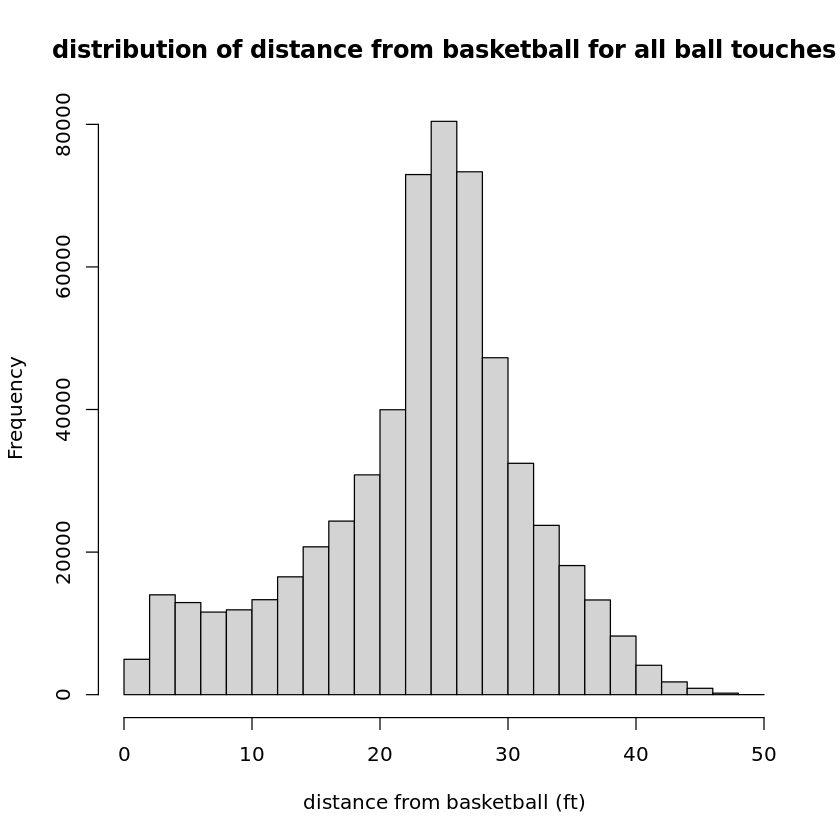

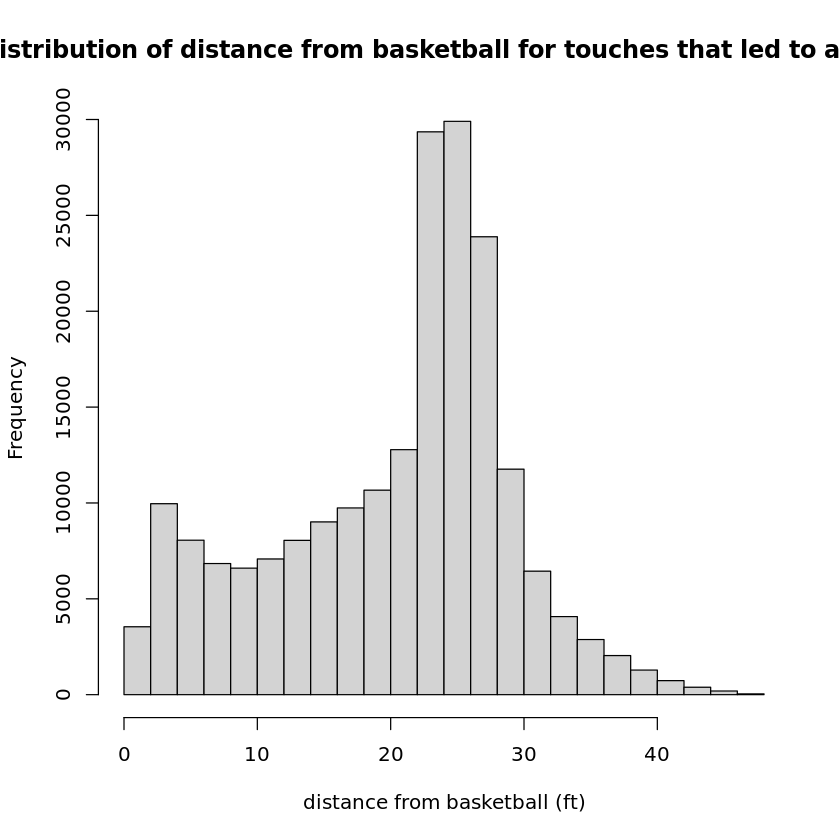

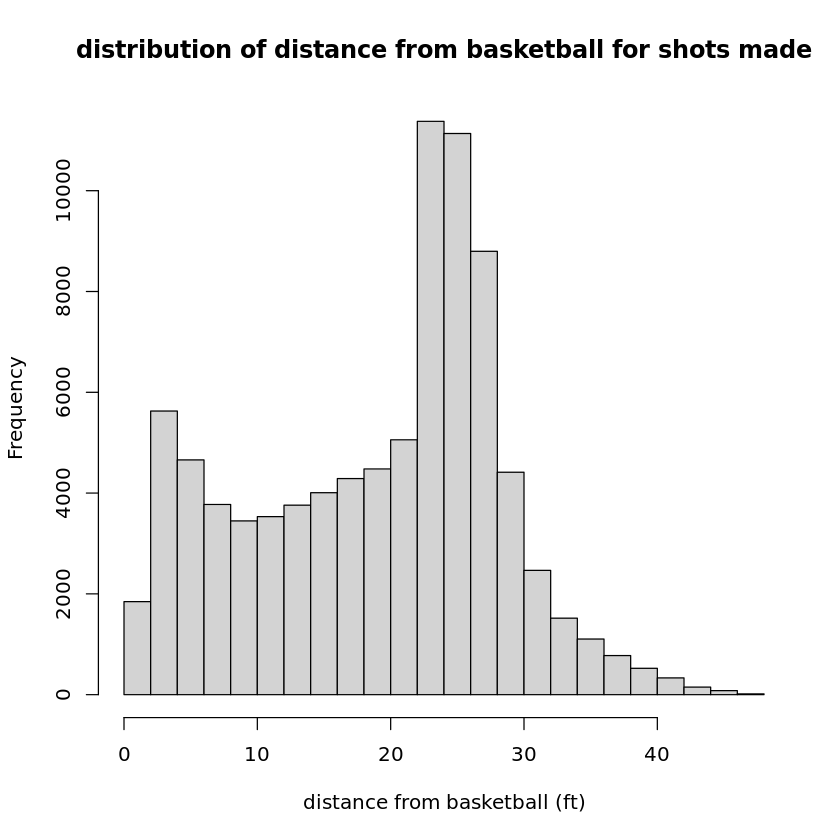

In [9]:
hist(touch_data$basket_distance,main='distribution of distance from basketball for all ball touches'
     ,xlab='distance from basketball (ft)')

hist(touch_data[touch_data$led_to_shot==T,]$basket_distance,
     main='distribution of distance from basketball for touches that led to a shot',
    xlab='distance from basketball (ft)')

hist(touch_data[touch_data$shot_result==T,]$basket_distance,
    main='distribution of distance from basketball for shots made',
     xlab='distance from basketball (ft)')


We can see from above that a good portion of ball touches are inside the 3-point line (the perimeter the paint), with the majority being on its border (peak around the ~24 ft mark). when it comes to touches that lead to a shot, the same thing applies but with a bigger portion inside the 3-point line (particularly in the paint). as for shots that were made, the portion inside the paint gets higher with the majority still around the 3-point line.

Now let's look at the numbers in term pf percentages. To do that we might need to create bins for the distance from the basketball

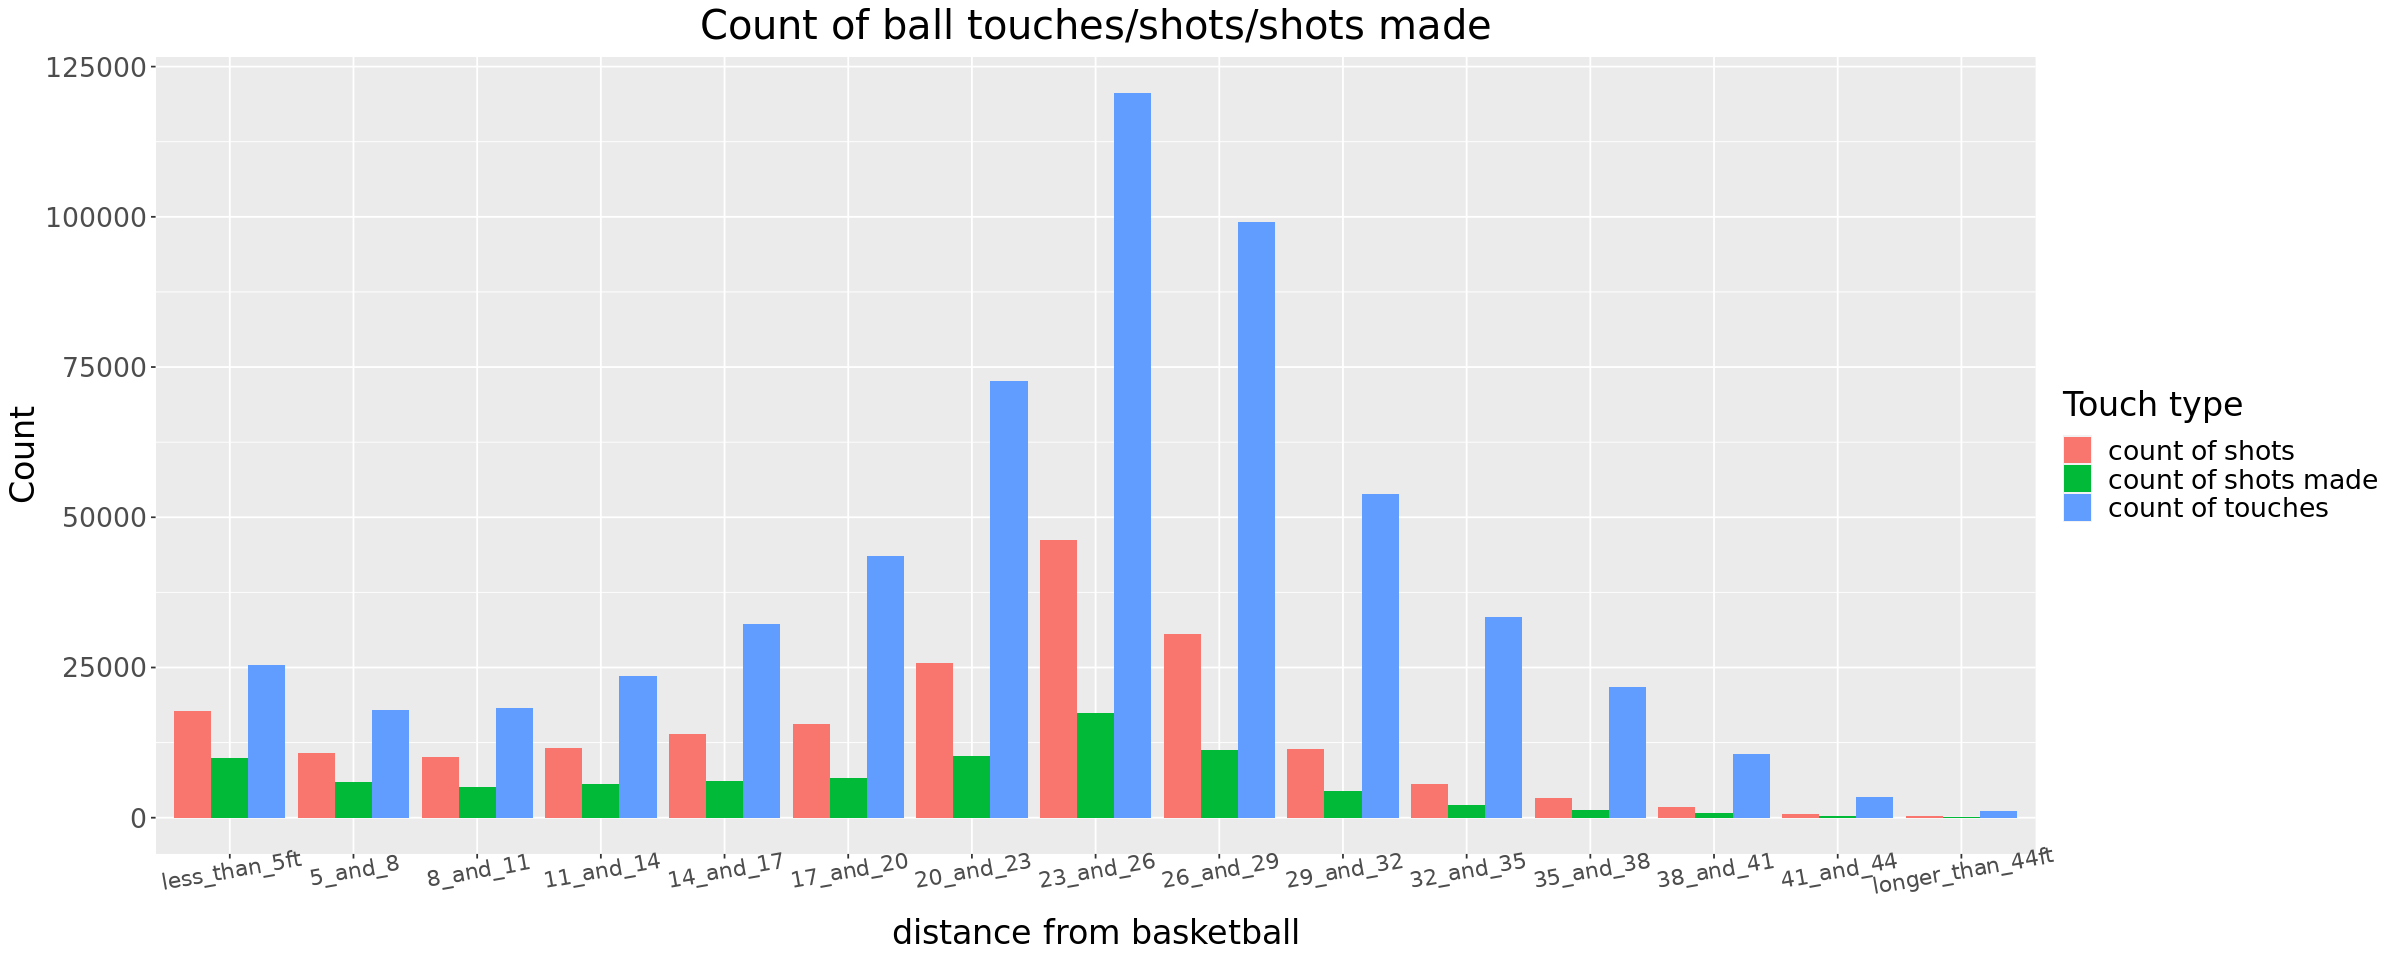

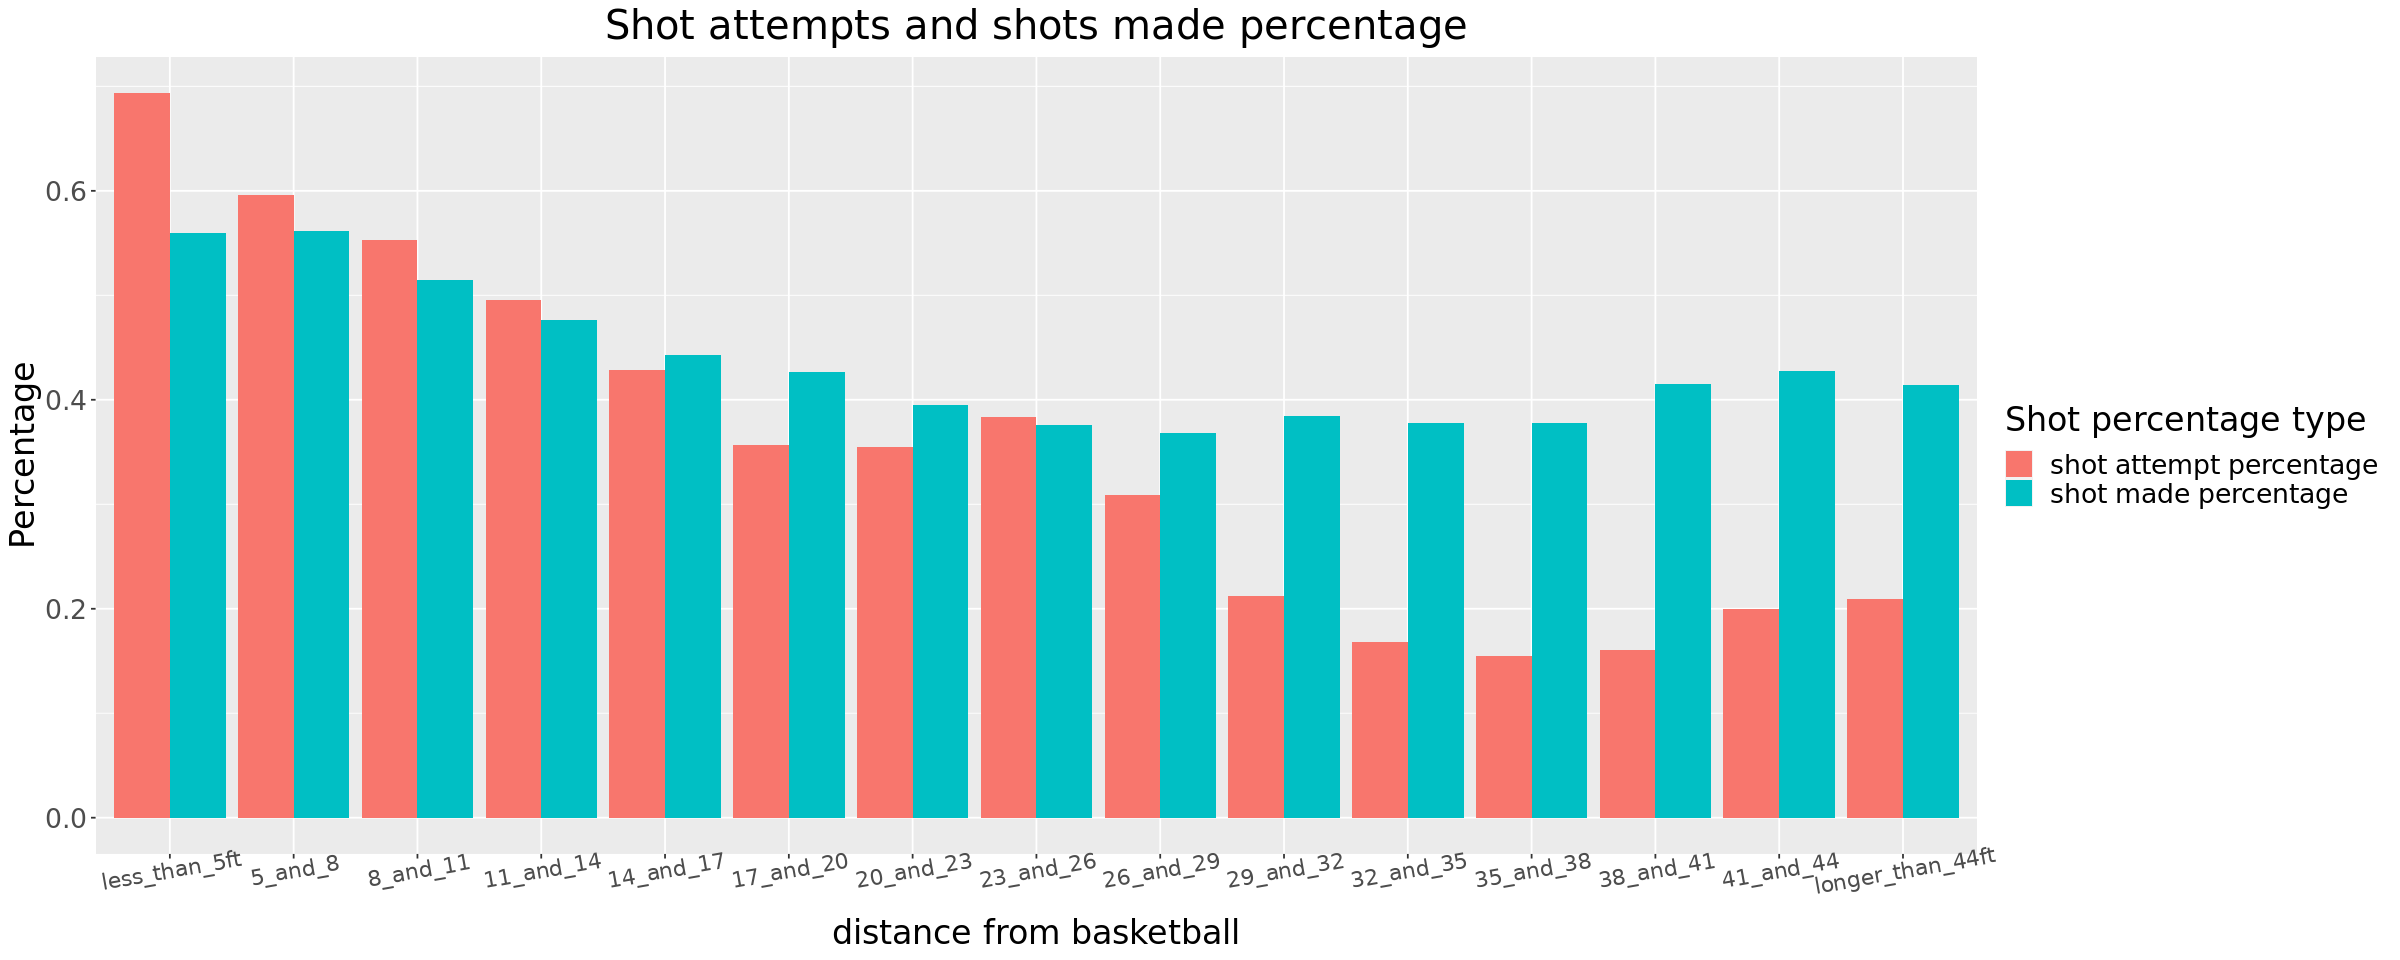

In [10]:

touch_data$dist_group=" "

touch_data$dist_group[touch_data$basket_distance <5]="less_than_5ft"
touch_data$dist_group[touch_data$basket_distance >=5 & touch_data$basket_distance <8]="5_and_8"
touch_data$dist_group[touch_data$basket_distance >=8 & touch_data$basket_distance <11]="8_and_11"
touch_data$dist_group[touch_data$basket_distance >=11 & touch_data$basket_distance <14]="11_and_14"
touch_data$dist_group[touch_data$basket_distance >=14 & touch_data$basket_distance <17]="14_and_17"
touch_data$dist_group[touch_data$basket_distance >=17 & touch_data$basket_distance <20]="17_and_20"
touch_data$dist_group[touch_data$basket_distance >=20 & touch_data$basket_distance <23]="20_and_23"
touch_data$dist_group[touch_data$basket_distance >=23 & touch_data$basket_distance <26]="23_and_26"
touch_data$dist_group[touch_data$basket_distance >=26 & touch_data$basket_distance <29]="26_and_29"
touch_data$dist_group[touch_data$basket_distance >=29 & touch_data$basket_distance <32]="29_and_32"
touch_data$dist_group[touch_data$basket_distance >=32 & touch_data$basket_distance <35]="32_and_35"
touch_data$dist_group[touch_data$basket_distance >=35 & touch_data$basket_distance <38]="35_and_38"
touch_data$dist_group[touch_data$basket_distance >=38 & touch_data$basket_distance <41]="38_and_41"
touch_data$dist_group[touch_data$basket_distance >=41 & touch_data$basket_distance <44]="41_and_44"
touch_data$dist_group[touch_data$basket_distance >=44 ]="longer_than_44ft"



touch_data$dist_group=factor(touch_data$dist_group,levels=c("less_than_5ft", "5_and_8", "8_and_11","11_and_14","14_and_17","17_and_20","20_and_23",
"23_and_26","26_and_29","29_and_32","32_and_35","35_and_38",
"38_and_41","41_and_44","longer_than_44ft"))




ballh_dist=as.data.frame(prop.table(table(touch_data$dist_group)))
ballh_dist$dist_group=factor(ballh_dist$Var1,levels=c("less_than_5ft", "5_and_8", "8_and_11","11_and_14","14_and_17","17_and_20","20_and_23",
"23_and_26","26_and_29","29_and_32","32_and_35","35_and_38",
"38_and_41","41_and_44","longer_than_44ft"))
ballh_dist$ballh_dist_Freq=signif(ballh_dist$Freq*100,3)


led_to_shot=as.data.frame(prop.table(table(touch_data[touch_data$led_to_shot==T,]$dist_group, touch_data[touch_data$led_to_shot==T,]$led_to_shot)))
led_to_shot=led_to_shot %>% filter(Var2==T)
led_to_shot$dist_group=factor(led_to_shot$Var1,levels=c("less_than_5ft", "5_and_8", "8_and_11","11_and_14","14_and_17","17_and_20","20_and_23",
"23_and_26","26_and_29","29_and_32","32_and_35","35_and_38",
"38_and_41","41_and_44","longer_than_44ft"))
led_to_shot$led_to_shot_Freq=signif(led_to_shot$Freq*100,3)

shot_result=as.data.frame(prop.table(table(touch_data[touch_data$shot_result==T,]$dist_group, touch_data[touch_data$shot_result==T,]$shot_result)))
shot_result=shot_result %>% filter(Var2==T)
shot_result$dist_group=factor(shot_result$Var1,levels=c("less_than_5ft", "5_and_8", "8_and_11","11_and_14","14_and_17","17_and_20","20_and_23",
"23_and_26","26_and_29","29_and_32","32_and_35","35_and_38",
"38_and_41","41_and_44","longer_than_44ft"))
shot_result$shot_result_Freq=signif(shot_result$Freq*100,3)




ballh_dist=touch_data %>% group_by(dist_group) %>% tally(name='count of touches')
led_to_shot=touch_data[touch_data$led_to_shot==T,] %>% group_by(dist_group) %>% tally(name='count of shots')
shot_result=touch_data[touch_data$led_to_shot==T & touch_data$shot_result==T,] %>% group_by(dist_group) %>% tally(name='count of shots made')


ball_distance_merged=merge(subset(ballh_dist,select=c(dist_group,`count of touches`)),subset(led_to_shot,select=c(dist_group,`count of shots`)),by="dist_group")


ball_distance_merged=merge(ball_distance_merged,subset(shot_result,select=c(dist_group,`count of shots made`)),by="dist_group")


ball_distance_merged$'shot attempt percentage'=ball_distance_merged$`count of shots`/ball_distance_merged$`count of touches`
ball_distance_merged$'shot made percentage'=ball_distance_merged$`count of shots made`/ball_distance_merged$`count of shots`


#table(touch_data$bh_pos)


ball_distance_merged <- ball_distance_merged %>%
  gather("Stat", "Value", -dist_group)


ball_distance_count=ball_distance_merged[ball_distance_merged$Stat=='count of touches' | ball_distance_merged$Stat=='count of shots' | ball_distance_merged$Stat=='count of shots made',]

ball_distance_percentage=ball_distance_merged[ball_distance_merged$Stat=='shot attempt percentage' | ball_distance_merged$Stat=='shot made percentage',]

saved <- options(repr.plot.width=20, repr.plot.height=8)

ggplot(ball_distance_count, aes(x = dist_group, y = Value, fill = Stat),alpha=.1) +
  geom_col(position = "dodge") + ggtitle("Count of ball touches/shots/shots made")+ xlab("distance from basketball") + ylab("Count") + labs(fill = "Touch type") + theme(plot.title = element_text(hjust = 0.5),axis.text.x = element_text(angle = 10,size = 13),text = element_text(size = 20))




ggplot(ball_distance_percentage, aes(x = dist_group, y = Value, fill = Stat),alpha=.1) +
  geom_col(position = "dodge") + ggtitle("Shot attempts and shots made percentage") + xlab("distance from basketball") + ylab("Percentage") + labs(fill="Shot percentage type") + theme(plot.title = element_text(hjust = 0.5),axis.text.x = element_text(angle = 10,size=13),text = element_text(size = 20))

options(saved)

From above we can see the differnt touch counts side by side. We can also see the shot attempt percentage and shots made percentage for different distances from the basketball. In terms of percentage, see that the closer the distance to the basketball the higher the shot percentage is. The same trend os seen for the shots made percentage where it's highest (more tha 55%) close to the basketball and it goes lower to around 40% at the 3-point line. The percentage stays almost flat the farther we go from the basketball is. It goes a bit higher at 40 ft and and above (around 42%)

### Time on Shot Clock

How does the time on shot clock affect the different types of ball touches? Let's explore below

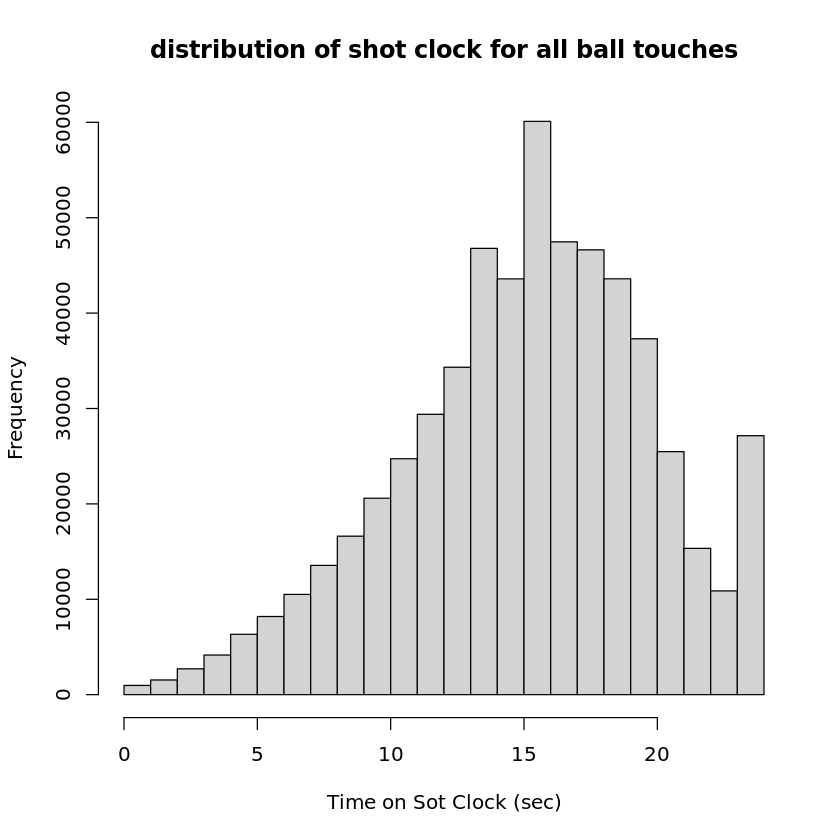

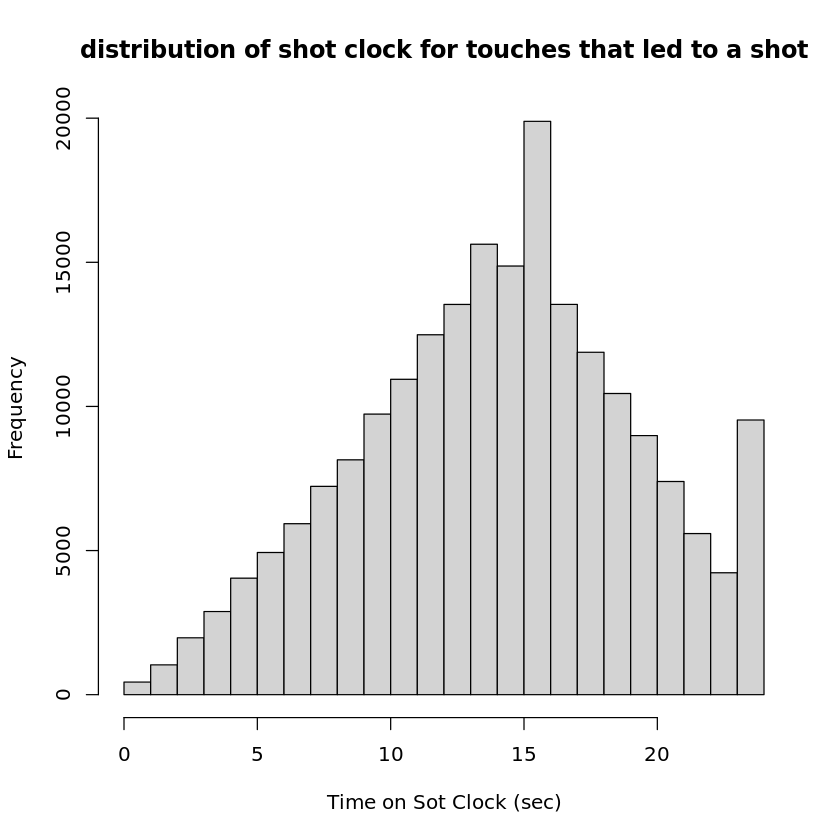

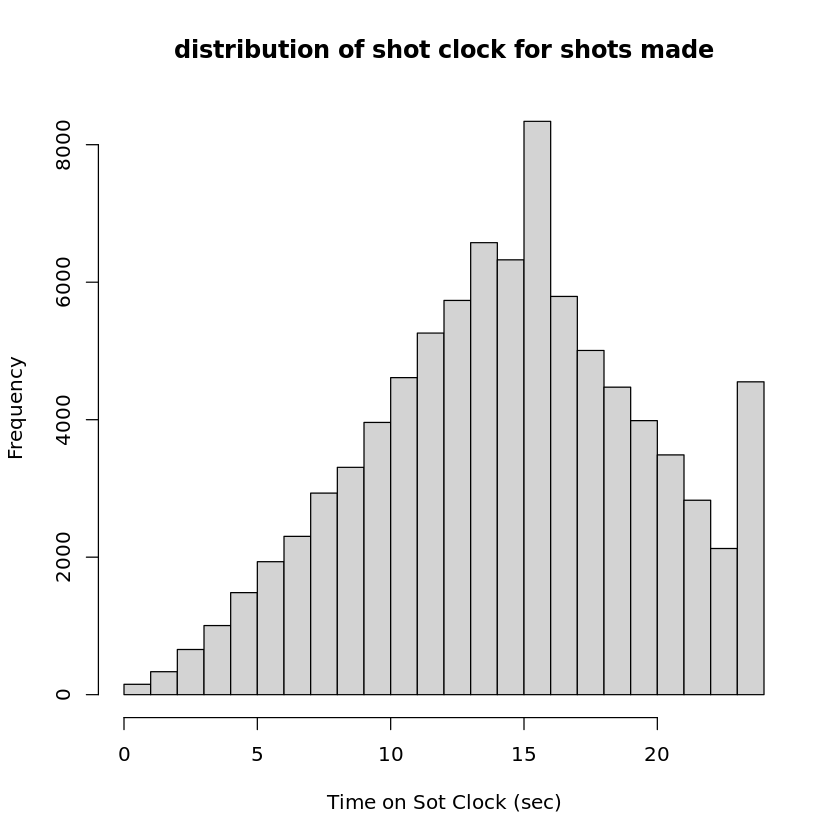

In [11]:
hist(touch_data$start_shot_clock,main='distribution of shot clock for all ball touches'
     ,xlab='Time on Sot Clock (sec)')

hist(touch_data[touch_data$led_to_shot==T,]$start_shot_clock,
     main='distribution of shot clock for touches that led to a shot',
    xlab='Time on Sot Clock (sec)')

hist(touch_data[touch_data$shot_result==T,]$start_shot_clock,
    main='distribution of shot clock for shots made',
     xlab='Time on Sot Clock (sec)')


Histogram of time on shot clock shows that all three ball touch types haver an almost similar distribution. There is apeak for the distribution in the 12 - 18 sec range. For total ball touches the peak is around 16 secs. For shot attempts and shots made it's around 13~14 secs

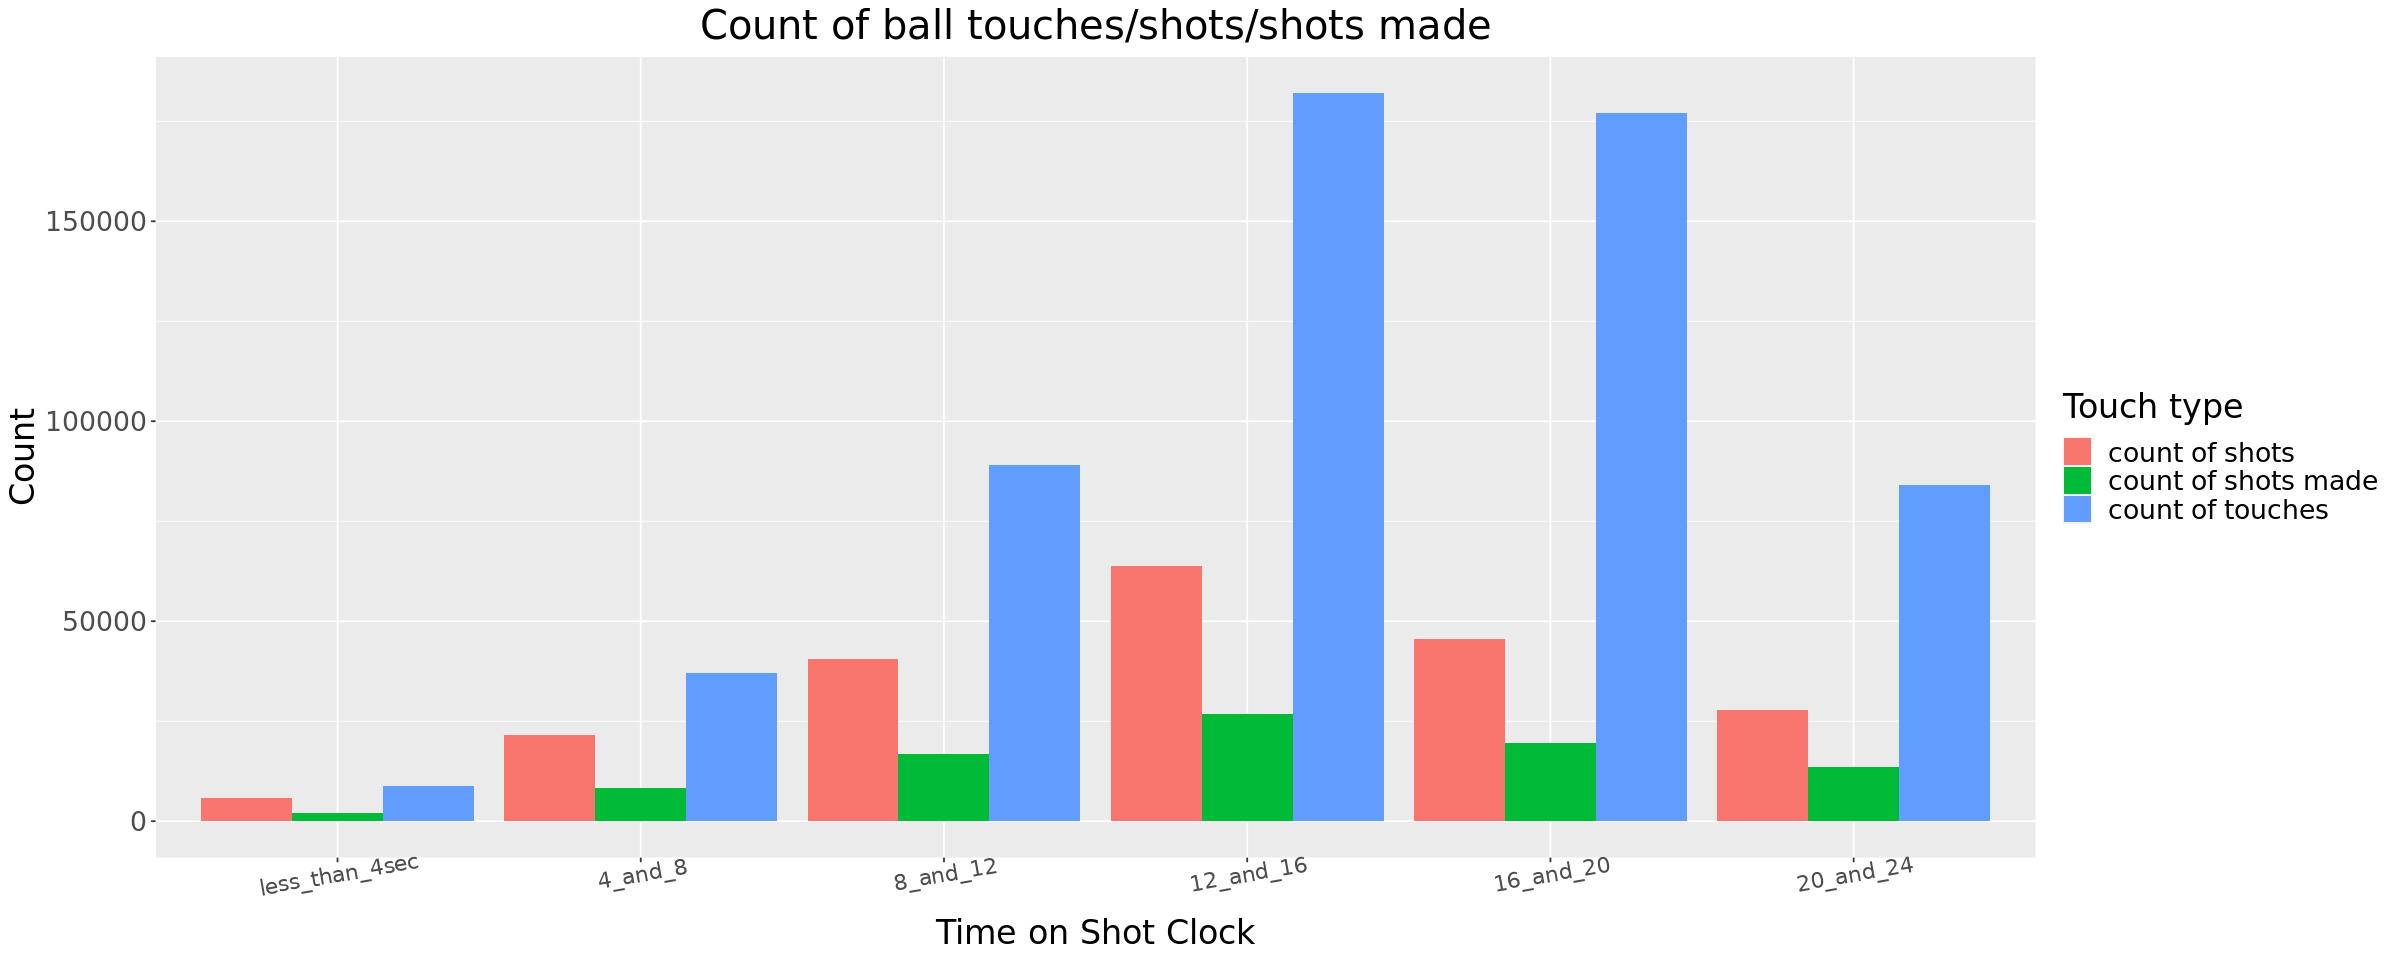

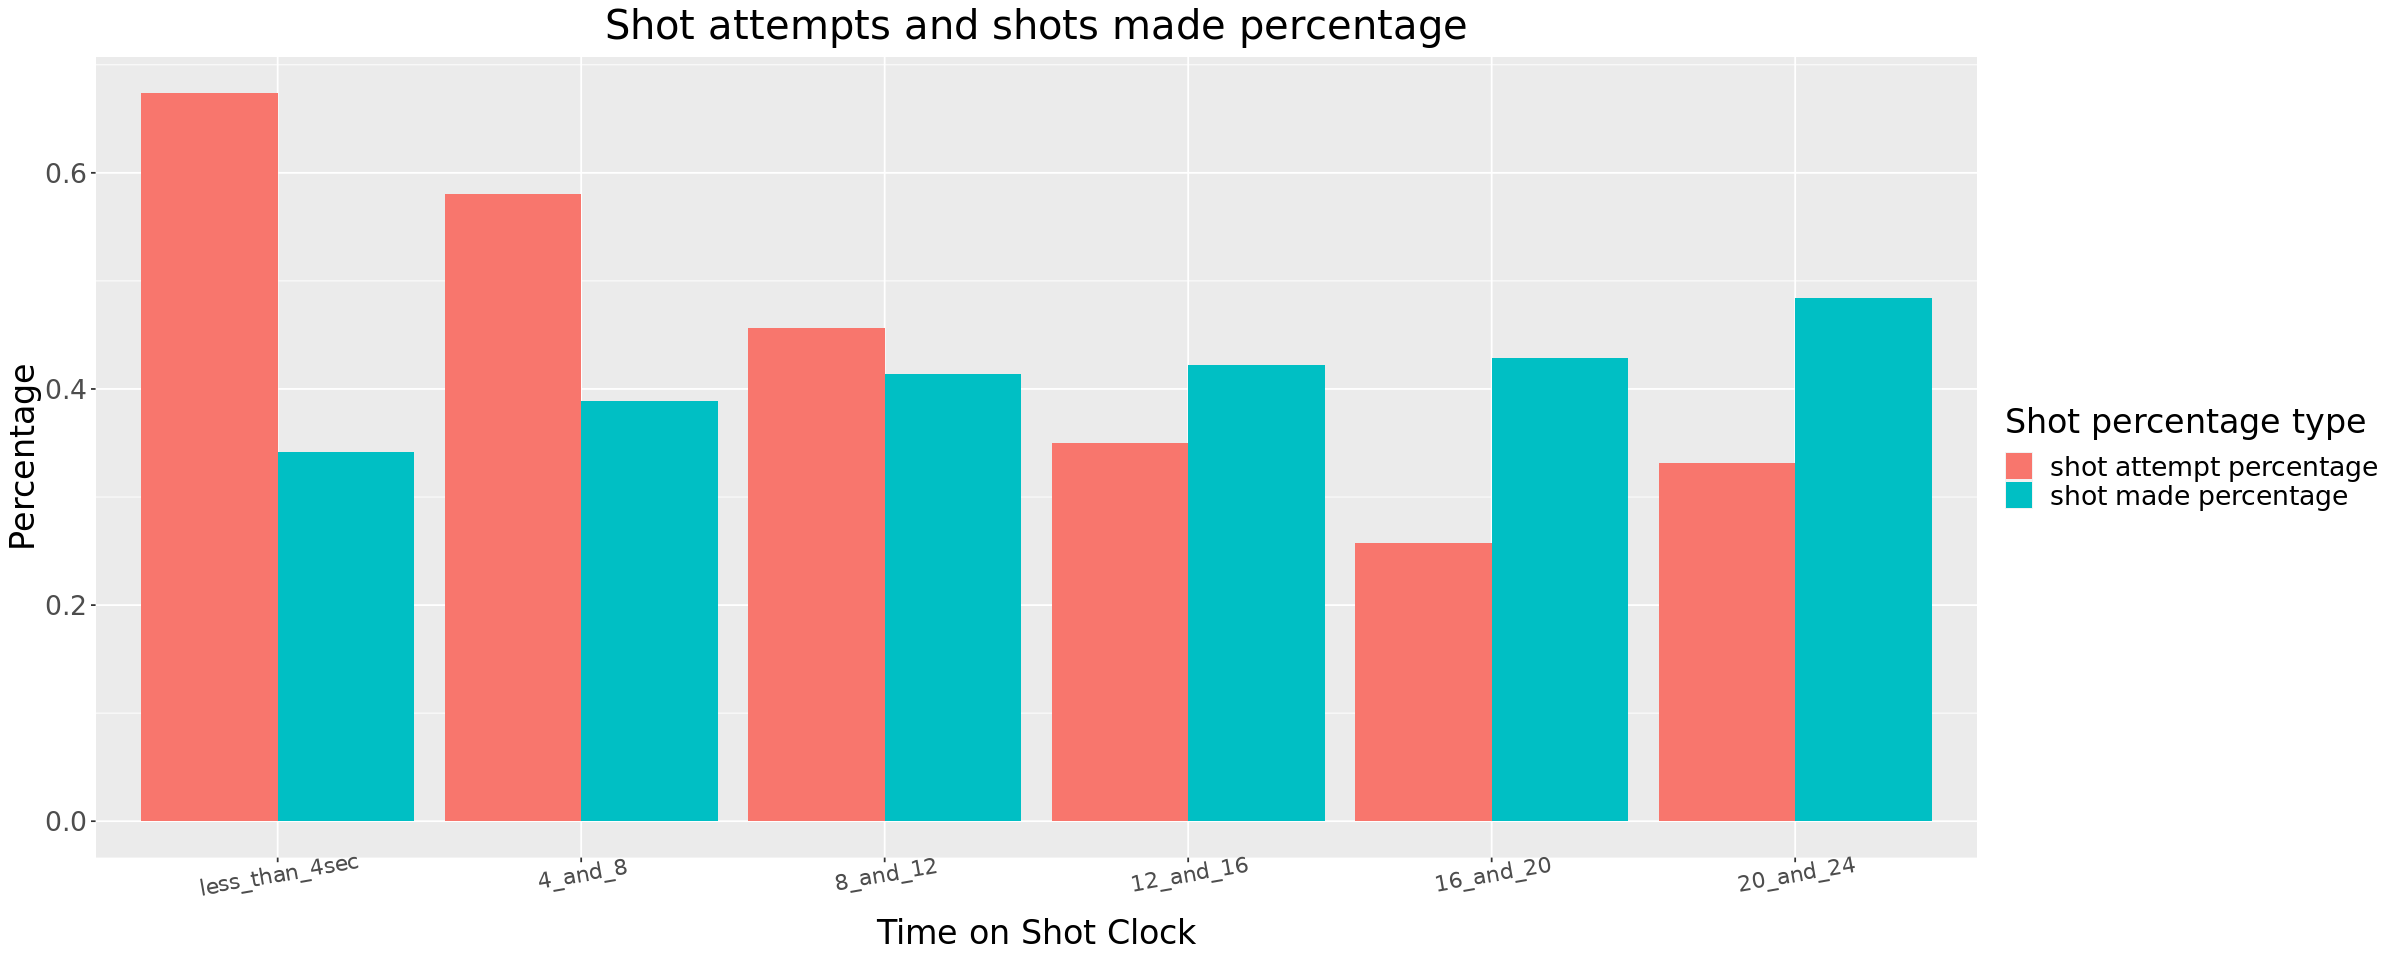

In [12]:


touch_data$time_group=" "

touch_data$time_group[touch_data$start_shot_clock <4]="less_than_4sec"
touch_data$time_group[touch_data$start_shot_clock >=4 & touch_data$start_shot_clock <8]="4_and_8"
touch_data$time_group[touch_data$start_shot_clock >=8 & touch_data$start_shot_clock <12]="8_and_12"
touch_data$time_group[touch_data$start_shot_clock >=12 & touch_data$start_shot_clock <16]="12_and_16"
touch_data$time_group[touch_data$start_shot_clock >=16 & touch_data$start_shot_clock <20]="16_and_20"
touch_data$time_group[touch_data$start_shot_clock >=20 ]="20_and_24"



touch_data$time_group=factor(touch_data$time_group,levels=c("less_than_4sec", "4_and_8", "8_and_12","12_and_16","16_and_20","20_and_24","20_and_23"))




ballh_time=as.data.frame(prop.table(table(touch_data$time_group)))
ballh_time$time_group=factor(ballh_time$Var1,levels=c("less_than_4sec", "4_and_8", "8_and_12","12_and_16","16_and_20","20_and_24","20_and_23"))
ballh_time$ballh_time_Freq=signif(ballh_time$Freq*100,3)


led_to_shot=as.data.frame(prop.table(table(touch_data[touch_data$led_to_shot==T,]$time_group, touch_data[touch_data$led_to_shot==T,]$led_to_shot)))
led_to_shot=led_to_shot %>% filter(Var2==T)
led_to_shot$time_group=factor(led_to_shot$Var1,levels=c("less_than_4sec", "4_and_8", "8_and_12","12_and_16","16_and_20","20_and_24","20_and_23"))
led_to_shot$led_to_shot_Freq=signif(led_to_shot$Freq*100,3)

shot_result=as.data.frame(prop.table(table(touch_data[touch_data$shot_result==T,]$time_group, touch_data[touch_data$shot_result==T,]$shot_result)))
shot_result=shot_result %>% filter(Var2==T)
shot_result$time_group=factor(shot_result$Var1,levels=c("less_than_4sec", "4_and_8", "8_and_12","12_and_16","16_and_20","20_and_24","20_and_23"))
shot_result$shot_result_Freq=signif(shot_result$Freq*100,3)




ballh_time=touch_data %>% group_by(time_group) %>% tally(name='count of touches')
led_to_shot=touch_data[touch_data$led_to_shot==T,] %>% group_by(time_group) %>% tally(name='count of shots')
shot_result=touch_data[touch_data$led_to_shot==T & touch_data$shot_result==T,] %>% group_by(time_group) %>% tally(name='count of shots made')


time_merged=merge(subset(ballh_time,select=c(time_group,`count of touches`)),subset(led_to_shot,select=c(time_group,`count of shots`)),by="time_group")


time_merged=merge(time_merged,subset(shot_result,select=c(time_group,`count of shots made`)),by="time_group")


time_merged$'shot attempt percentage'=time_merged$`count of shots`/time_merged$`count of touches`
time_merged$'shot made percentage'=time_merged$`count of shots made`/time_merged$`count of shots`


#table(touch_data$bh_pos)


time_merged <- time_merged %>%
  gather("Stat", "Value", -time_group)


time_count=time_merged[time_merged$Stat=='count of touches' | time_merged$Stat=='count of shots' | time_merged$Stat=='count of shots made',]

time_percentage=time_merged[time_merged$Stat=='shot attempt percentage' | time_merged$Stat=='shot made percentage',]

saved <- options(repr.plot.width=20, repr.plot.height=8)

ggplot(time_count, aes(x = time_group, y = Value, fill = Stat),alpha=.1) +
  geom_col(position = "dodge") + ggtitle("Count of ball touches/shots/shots made")+ xlab("Time on Shot Clock") + ylab("Count") + labs(fill = "Touch type") + theme(plot.title = element_text(hjust = 0.5),axis.text.x = element_text(angle = 10,size = 13),text = element_text(size = 20))




ggplot(time_percentage, aes(x = time_group, y = Value, fill = Stat),alpha=.1) +
  geom_col(position = "dodge") + ggtitle("Shot attempts and shots made percentage") + xlab("Time on Shot Clock") + ylab("Percentage") + labs(fill="Shot percentage type") + theme(plot.title = element_text(hjust = 0.5),axis.text.x = element_text(angle = 10,size=13),text = element_text(size = 20))

options(saved)



From above we see that the less time on the shot clock the higher the shot attempt percentage is. The opposite is seen for the shot made percentage. The rationale is that as the shot clock expires a shot attempt is usually rushed which is usually made in unfavorable situations